In [5]:
import pandas as pd
from scipy.stats import geom
import matplotlib.pyplot as plt
import numpy as np

In [10]:
#plt.rcParams['figure.autolayout'] = False
#plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = "\usepackage{subdepth}, \usepackage{type1cm}"

In [7]:
p=0.2

In [13]:
def plot_geom(p):
    rv = geom(p)
    x = np.arange(rv.ppf(0.01), rv.ppf(0.99))
    y = rv.pmf(x)
    mean = 1.0/p
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    ax.plot(x, y, 'ob')
    ax.vlines(x, 0, y, 'b')
    ax.set_xticks(x[::2])
    ax.set_xlabel("Years")
    ax.vlines(mean, 0, rv.pmf(mean), 'r', lw=4)
    ax.annotate('Average lifetime = {0} years'.format(mean), (mean, rv.pmf(mean)), (5, 5), textcoords='offset pixels', fontsize='x-large')

In [27]:
def plot_exp(p):
    rv = geom(p)
    x = np.arange(1, 50)
    y = rv.pmf(x)
    exp = np.cumsum(x*y)
    mean = 1.0/p
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    ax.plot(x, exp, 'ob')
    ax.set_xlabel("Years")
   

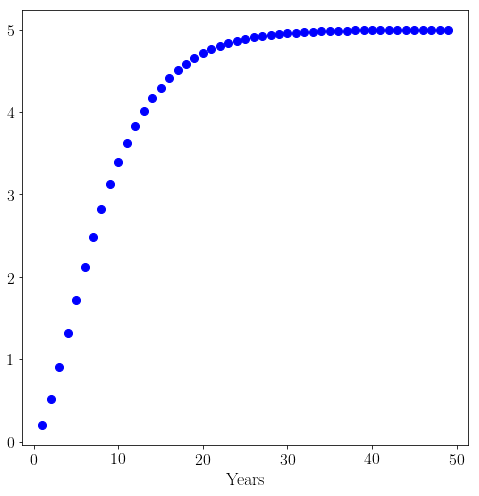

In [28]:
plot_exp(0.2)

Recently I was listening to Tom, our CEO, explain how we use average customer lifetime in our Return on Investment (ROI) business cases - it is one of many elements that we must estimate when building a ROI case for our customers. Tom explained how we use $\frac{1}{\text{Churn}}$, in order to estimate average customer lifetime - this is a common approach to estimating average lifetime. For example if we know that the churn is 20%, we would estimate the average lifetime as $\frac{1}{0.2}$ = 5 years.

Listening to him, I realised, I didn't know why this was valid. It is a simple estimate and seems to work, but I wanted to dig into why its used a bit more.

To understand this, its probably important to explain what we mean by churn in this context. We can define churn as the probability that at the end of a year a customer will leave. For example, if our churn was 50% (!) then at the end of a year, we flip a coin: heads the customer churns, tails the customer is retained. Obviously if we can pick any timescale, it doesn't have to be a one year (it could be daily, weekly or monthly churn).

Clearly 50% churn is insane, so lets continue by assuming a 20% churn rate. We can write the *probability* of a customer churning after 1 year like this:

\begin{align}
P(Y = 1) & = 0.2
\end{align}

We can also ask the question - what is the probability that a customer will churn after two years? Well in this case  we succesfully retained them in year 1 (we had a 80% chance of retaining), but they churned at the end of year 2. So the probability of churning after 2 years is:

\begin{align}
P(Y = 2) & = 0.8 \times 0.2 = 0.16 \\
\end{align}

We have a 0.16 or 16% chance of a customer churning after two years. Similarly we can ask what is the chance of a customer churning after 3 years, or even 10 years (we retain them for 9 years and then they churn at the end of year 10)?

\begin{align}
P(Y = 3) & = 0.8 \times 0.8 \times 0.2 = 0.128 \\
P(Y = 10) & = 0.8 \times 0.8 \times 0.8 \times 0.8 \times 0.8 \times 0.8 \times 0.8 \times 0.8 \times 0.8 \times 0.2 = 0.027 \\
\end{align}

So we have a 12.8% chance of a customer churning after 3 years (i.e. they had a lifetime of 3 years) and a 2.7% of a customer having a 10 year lifetime. Clearly that last one was a little tedious to write, so in general we write it as:

\begin{align}
P(Y=y) &= p\ (1-p)^{ y-1} && \text{for}\ y = 1, 2, 3 \dots
\end{align}

This is called the probability mass function for the **geometric distribution**, sometimes called the **shifted geometric distribution**. It is a probability distribution used to model the number of trials (in our case years) up to an event (in our case a churn event).

To show how it related to our earlier examples, for a 20% churn probability, $p=0.2$:

\begin{align*}
P(Y=y) &= p\ (1-p)^{ y-1} \\
P(Y=y) &= 0.2\cdot (1-0.2)^{ y-1} \\
P(Y=y) &= 0.2\cdot 0.8^{ y-1} 
\end{align*}

We can plot this out to visualise the chance of a customer churning after 1,2,3,4... years:

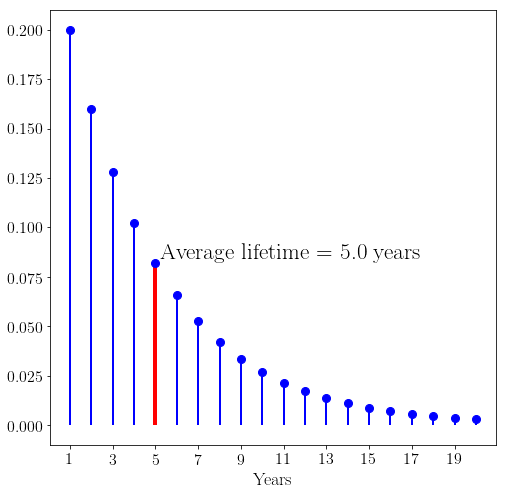

In [14]:
plot_geom(0.2)

We can also plot this distribution for a different churn probability, e.g. 10%:

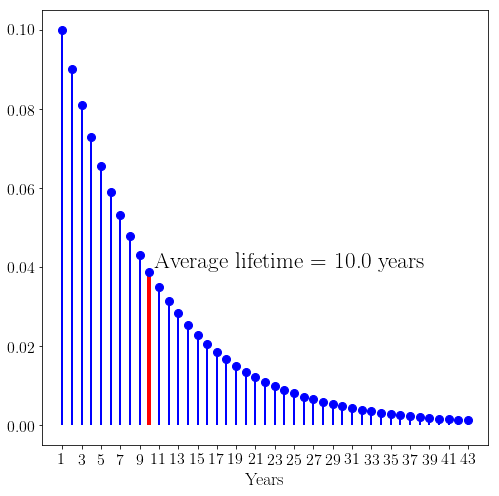

In [15]:
plot_geom(0.1)

In the first plot, as expected we can see the churn probabilities of 20% after one year, 16% after two years etc. Interestingly the probability of retaining a customer for five years is only 8.2% and yet this is the average customer lifetime! How can this be? 

The answer lies in the long-tail of this distribution. Even though the most common lifetime (the mode) is 1 year, the average or mean is 5 years. That is, most customers will churn after 1 year, but some will stay for 2 years and some will only churn after 10 or even 20 (or even longer) years. In this model, these longer-term, loyal customers average out the shorter lifetime customers.

We can calculate the average lifetime by calculating a weighted sum of *the lifetime of a customer multiplied by how likely a customer is to have that lifetime*. So 20% of customers are likely to have a 1 year lifetime, 

\begin{align}
&= 0.2 \times 1 + 0.16 \times 2 + 0.128 \times 3 \dots \\
&= 0.2 + 0.32 + 0.384 + 0.4096
\end{align}

We can write this using the probability equation from earlier:

\begin{align}
\text{Average Lifetime} =  p\ (1-p)^{0} \times 1 + p\ (1-p)^{1} \times 2 + p\ (1-p)^{2} \times 3 \dots && \text{where p=0.2}
\end{align}

Although this is a long sum (that goes on forever!), it turns out that we can simplify this with some maths and prove that the Average Lifetime = $\frac{1}{p}$

Before we get to that, its worth explaining the limitations of this model. Firstly this model assumes that the probability a customer will churn is always 20% *regardless* of previous years outcomes. This is known as independence. This intuitively feels a bit weird - maybe you'd expect your first year churn to be 20%, but if a customer is retained perhaps the probability drops off sharply - this breaks independence. 

The second assumption is that the churn probability is always 20% - again maybe this depends on the type of customer e.g. perhaps smaller customers churn more easily. We may many pieces of information about a customer e.g. how engaged they were, when they last responded to an email, how rapidly they've grown. These 'signals' can't be incorporated into the simple model above.

Finally it might not be as simple as churn / retained - perhaps some customers become dormant or go out of business - maybe we want to model these differently.

For more sophisticated challenges, a more sophisticated approach, e.g. using Machine Learning, can help overcome these limitations.

## Proving that the average lifetime is $\frac{1}{p}$

In order to exactly calculate the Average Customer Lifetime, we need to calculate this sum to infinity. This is called the mean or **expectation** of the probability distribution. The expectation, *E*, is given by:

\begin{align}
E[Y] &= \sum_{y=1}^{\infty} P(Y=y)\cdot y 
\end{align}

To remind ourselves, we are trying to prove that this expectation is actually just $\frac{1}{p}$ or 1 / churn. Lets work through this, substituting in for $P(Y=y)$ from earlier. 

\begin{align}
E[Y] &= \sum_{y=1}^{\infty} p\ (1-p)^{ y-1}y \\
E[Y] &= p \sum_{y=1}^{\infty} (1-p)^{ y-1}y 
\end{align}

Lets substitute $q = 1-p$ for convenience:

\begin{align}
E[Y] &= p \sum_{y=1}^{\infty} q^{ y-1}y 
\end{align}

The trick here is to recognise that the summation can be replaced by a derivative of another summation, using THIS fact.

\begin{equation*}
E[Y] = p \frac{d}{dq} \Big( \sum_{y=0}^{\infty} q^{ y} \Big) 
\end{equation*}

Now, we can recognise we have a geometric series. As we know that $q < 1$, the geometric series $\sum_{y=0}^{\infty} q^{y}$ will converge to $\frac{1}{1-q}$ or $(1-q)^{-1}$
We can subsitute this for the summation:

\begin{equation*}
E[Y] = p \frac{d}{dq} \big( (1-q)^{-1} \big) \\
\end{equation*}

If we evaluate the derivative and simplify:

\begin{align}
E[Y] &= p \big( \text{-1} \cdot \text{-1}\cdot(1-q)^{-2} \big) \\
E[Y] &= \frac{p}{(1-q)^{2}} \\
E[Y] &= \frac{p}{(1-(1-p))^{2}} \\
E[Y] &= \frac{p}{p^{2}} \\
E[Y] &= \frac{1}{p}
\end{align}

Hence, we know for the geometric distribution, the mean is $\frac{1}{p}$, which is exactly what we set out to show.